# Introduction

# Imports

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
dataset_location = '~/.pytorch/MNIST_data/'

In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),                  # this will convert to 0..1 range tensor in NCHW format
    transforms.Normalize((0.5,), (0.5,))    # this will convert to -1..1 range
])

In [26]:
trainset = datasets.MNIST(dataset_location, download=True, train=True, transform=transform)
testset = datasets.MNIST(dataset_location, download=True, train=False, transform=transform)

In [27]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True, pin_memory=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True, pin_memory=True, num_workers=2)

For testing, we will load single batch from dataset

In [28]:
images, labels = iter(trainloader).next()

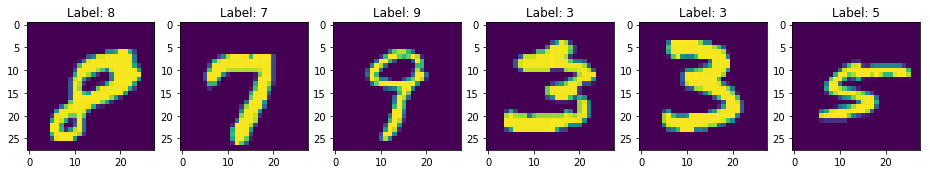

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in range(len(axes)):
    axes[i].set_title('Label: '+str(labels[i].item()))
    axes[i].imshow(images[i, 0])

In [30]:
print('images:')
print('shape', images.shape)
print(images[0, 0, 10:18, 10:18])

images:
shape torch.Size([1000, 1, 28, 28])
tensor([[-0.5765,  0.9765,  0.9765,  0.9765,  0.9765,  0.7333,  0.4510, -0.0980],
        [ 0.1922,  0.9765,  0.9765,  0.7333,  0.0039, -0.7255, -1.0000, -1.0000],
        [ 0.8118,  0.9765,  0.1137, -0.7412, -1.0000, -1.0000, -1.0000, -1.0000],
        [ 0.9765,  0.7725, -0.7333, -1.0000, -1.0000, -0.8980, -0.7882,  0.1451],
        [ 0.9765,  0.6784, -0.9608, -0.9922, -0.8902,  0.5451,  0.9765,  0.9765],
        [ 0.9765,  0.9765,  0.3804,  0.0902,  0.9765,  0.9843,  0.9765,  0.9765],
        [ 0.9843,  0.9843,  0.9843,  0.9843,  0.9843,  1.0000,  0.9843,  0.9843],
        [ 0.9765,  0.9765,  0.9765,  0.9765,  0.9765,  0.9843,  0.6235,  0.1373]])


In [31]:
print('labels:')
print('shape', labels.shape)
print(labels[0:10])

labels:
shape torch.Size([1000])
tensor([8, 7, 9, 3, 3, 5, 5, 3, 4, 8])


# PyTorch Model

In [32]:
def accuracy(pred, tar): 
    return (pred == tar).float().mean()  # tensor!!

In [33]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [34]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=784, out_features=512),
    nn.ELU(),
    nn.Dropout(0.2),
    nn.Linear(in_features=512, out_features=512),
    nn.ELU(),
    nn.Dropout(0.2),
    nn.Linear(in_features=512, out_features=10),  # no softmax
)
model.to(device)
criterion = nn.CrossEntropyLoss()                 # softmax included in here
optimizer = torch.optim.Adam(model.parameters())
print(model)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ELU(alpha=1.0)
  (3): Dropout(p=0.2)
  (4): Linear(in_features=512, out_features=512, bias=True)
  (5): ELU(alpha=1.0)
  (6): Dropout(p=0.2)
  (7): Linear(in_features=512, out_features=10, bias=True)
)


Train model

In [35]:
import time

In [39]:
def train():

    hist = { 'loss':[], 'acc':[] }

    ts = time.time()

    for epoch in range(5):  # loop over the dataset multiple times

        for x, y in trainloader:
            x, y = x.to(device), y.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                _, predictions = torch.max(outputs, 1)
                hist['acc'].append( accuracy(predictions, y).item() )
                hist['loss'].append( loss.item() )

    print(time.time() - ts)
    
    return hist

In [42]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [43]:
%lprun -f train train()

32.05396628379822


In [ ]:
datasets

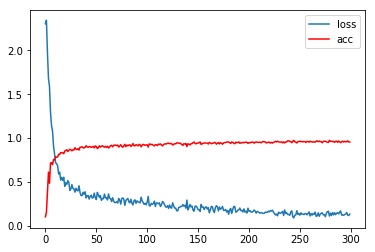

In [17]:
plt.plot(hist['loss'], label='loss')
plt.plot(hist['acc'], label='acc', color='red')
plt.legend();